Copyright (c) 2012-2021 Esri R&D Center Zurich

Licensed under the Apache License, Version 2.0 (the "License");
you may not use this file except in compliance with the License.
You may obtain a copy of the License at

  https://www.apache.org/licenses/LICENSE-2.0

Unless required by applicable law or agreed to in writing, software
distributed under the License is distributed on an "AS IS" BASIS,
WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
See the License for the specific language governing permissions and
limitations under the License.
A copy of the license is available in the repository's LICENSE file.

 # PyPRT - Creation of 3D GIS Content (Parks)


In [1]:
import sys
import os
import random
import string

from arcgis.gis import GIS
from arcgis.geocoding import geocode

import pyprt
from pyprt.pyprt_arcgis import arcgis_to_pyprt

gis = GIS(username='my_username') # Enter your AGOL username.

Enter password: ········


In [2]:
pyprt.initialize_prt()

if(not pyprt.is_prt_initialized()):
    raise Exception("PRT is not initialized")

[PRT] [2021-04-23 08:16:09] [error] failed to load library: error while loading library 'c:\users\cami9495\documents\esri-cityengine-sdk-master\examples\pyprt-examples-main\.venv\lib\site-packages\pyprt\pyprt\lib\com.esri.prt.unreal.dll': The specified module could not be found.

[PRT] [2021-04-23 08:16:09] [warning] failed to load library com.esri.prt.unreal.dll


### Story: Zürich Bahnhofstrasse

In [3]:
existing_id = '65696aefd99445bf86bf682a7f2530c6'
existing = gis.content.get(existing_id)

In [4]:
map0 = gis.map(mode='3D')
location = geocode("Zurich")[0]
map0.extent = location['extent']
map0

MapView(layout=Layout(height='400px', width='100%'), mode='3D')

In [5]:
map0.add_layer(existing)

### Get parks parcels from ArcGIS Online

<Item title:"Zurich Parks Parcels" type:Feature Layer Collection owner:CLechot_zurich>
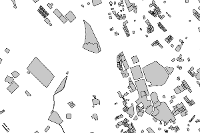

In [6]:
item_id = 'e9ff3ffc7445455d87c55551aafc6e54'
item = gis.content.get(item_id)
item

In [7]:
map1 = gis.map()
map1.extent = item.extent
map1.add_layer(item, {'opacity': 0.5})
map1

MapView(layout=Layout(height='400px', width='100%'))

#### Region delimiting/ IDs of the parks parcels to redevelop : Zürich old town

In [8]:
id_list = (192, 510, 797, 1026, 1031, 1247, 1533,
           1570, 1594, 2005, 2215, 2469, 2477, 2728)

In [9]:
filtered_parks_set = item.layers[0].query(
    where='shape__id IN ' + str(id_list), return_z=True)
filtered_parks_set

<FeatureSet> 14 features

In [10]:
map2 = gis.map()
map2.extent = item.extent
map2

MapView(layout=Layout(height='400px', width='100%'))

In [11]:
map2.add_layer(filtered_parks_set)
map2.zoom_to_layer(item=filtered_parks_set)

### Get the parcels geometry

In [12]:
initial_geometries_from_set = arcgis_to_pyprt(filtered_parks_set)

In [13]:
len(initial_geometries_from_set)

14

### PRT generation

<Item title:"Greenspace Construction_smallversion" type:Rule Package owner:CLechot_zurich>
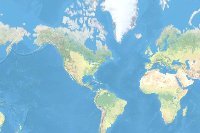

In [14]:
rpk_id = '2c31f077021b495cbfe4097227fdd78e'
rpk = gis.content.get(rpk_id)
attrs = {'shapeName': 'Trees'}
rpk

In [15]:
export_file_name = 'ex8_PyPRT_GeneratedParks'+ '_' + ''.join(random.choice(string.ascii_lowercase +
    string.digits) for x in range(5))
enc_optionsSLPK = {
    'sceneType': 'Local', 
    'baseName': export_file_name, 
    'sceneWkid': '3857', 
    'layerTextureEncoding': ['2'], 
    'layerEnabled': [True], 
    'layerUID': ['1'], 
    'layerName': ['1'], 
    'layerTextureQuality': [1.0], 
    'layerTextureCompression': [9], 
    'layerTextureScaling': [1.0], 
    'layerTextureMaxDimension': [2048], 
    'layerFeatureGranularity': ['0'], 
    'layerBackfaceCulling': [False], 
    'outputPath': os.path.join(os.getcwd(), 'ex8_output')}
os.makedirs(enc_optionsSLPK['outputPath'], exist_ok=True)

In [16]:
mod_parcel = pyprt.ModelGenerator(initial_geometries_from_set)
generated_parks = mod_parcel.generate_model(
    [attrs], rpk.download(), 'com.esri.prt.codecs.I3SEncoder', enc_optionsSLPK)

### From Python to ArcGIS

In [17]:
slpk_filepath = os.path.join(enc_optionsSLPK['outputPath'], export_file_name+'.slpk')

In [18]:
uploaded_item = gis.content.add({'type': 'Scene Package'}, data=slpk_filepath)

In [19]:
published_item = uploaded_item.publish()

In [20]:
display(published_item)

<Item title:"ex8_PyPRT_GeneratedParks_uz4aq" type:Scene Layer owner:CLechot_zurich>

### Visualization

In [21]:
map3 = gis.map(mode='3D')
map3.basemap = 'gray' 
map3.add_layer(published_item)
map3.add_layer(existing)
map3.zoom_to_layer(item=filtered_parks_set)
map3

MapView(layout=Layout(height='400px', width='100%'), mode='3D')

In [22]:
pyprt.shutdown_prt()